<a href="https://colab.research.google.com/github/marketakvasova/LSEC_segmentation/blob/main/automatic_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


# **Automatic segmentation of electron microscope images**

# 1. Setup

In [41]:
import os
from google.colab import drive
import torch.cuda
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torchsummary import summary
import shutil
import cv2 as cv
from numpy.lib.stride_tricks import as_strided
import pywt
from scipy.stats import norm
from google.colab.patches import cv2_imshow
import gc

gc.collect()
drive.mount('/content/gdrive')
model_folder = "./gdrive/MyDrive/ROI_patches/my_model"
os.makedirs(model_folder, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # TODO: do not even try this, if the gpu is not connected
print(DEVICE)
biomodel_folder = os.path.join(model_folder, "bioimageio_model")
biomodel_path = os.path.join(biomodel_folder, "weights.pt")
os.makedirs(biomodel_folder, exist_ok=True)
LOAD_TRAINED_MODEL = True

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda


# Utils

## Data utils

In [42]:
class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transofrm=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transofrm
        self.images = sorted(os.listdir(self.image_dir)) # listdir returns arbitrary order
        self.masks = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index]) # mask and image need to be called the same
        image = np.array(Image.open(img_path).convert('L')) # TODO: only grayscale images
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32) #TODO, ten float asi neni potreba
        mask[mask == 255.0] = 1
        return image, mask

class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        augmentations = self.transform(image=image, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
        return image, mask

    def __len__(self):
        return len(self.dataset)


def get_loaders(img_dir, mask_dir, split, batch_size, train_transform, val_transform, num_workers=4, pin_memory=True): # TODO: check these parameters
    data = MyDataset(
        image_dir=img_dir,
        mask_dir=mask_dir,
        transofrm=None
    )

    train_indices, test_indices = train_test_split(
        range(len(data)),
        test_size=split,
        random_state=42
    )
    train_data = TransformDataset(Subset(data, train_indices), train_transform)
    val_data = TransformDataset(Subset(data, test_indices), val_transform)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_loader, val_loader, train_indices

train_transform = A.Compose( # TODO: background(preprocessing?), intensity
    [
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.Affine(shear=(0.5,1)),
        # A.Affine(scale=(-10, 10)),
        A.Normalize(
            mean = 0.0,
            std = 1.0,
            max_pixel_value=255.0, # normalization to [0, 1]
        ),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(
            mean = 0.0,
            std = 1.0,
            max_pixel_value=255.0,
        ),
        ToTensorV2()
    ]
)

# test_transform = A.Compose(
#     [
#     A.Normalize(
#       mean = 0.0,
#       std = 1.0,
#       max_pixel_value=255.0,
#     ),
#         ToTensorV2()
#     ]
# )

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transformations if needed
])

def inference_on_image_with_overlap(model, image_path, output_folder):
    window_size = 512
    oh, ow = 124, 124
    input_image = cv.imread(image_path, 0)
    image_height, image_width = input_image.shape
    original_height, original_width = image_height, image_width
    bottom_edge = image_height % (window_size - oh)
    right_edge = image_width % (window_size - ow)
    mirrored_image = np.zeros((image_height+bottom_edge, image_width+right_edge)).astype(np.uint8)
    mirrored_image[:image_height, :image_width] = input_image
    mirrored_image[image_height:, :image_width] = np.flipud(input_image[image_height-bottom_edge:, :])
    mirrored_image[:, image_width:] = np.fliplr(mirrored_image[:, image_width-right_edge:image_width])
    image_height += bottom_edge
    image_width += right_edge
    weights = np.zeros((image_height, image_width))
    output_probs = np.zeros((image_height, image_width))
    output_mask = np.zeros((image_height, image_width))

    for x in range(0, image_height-window_size+1, window_size - oh):
        for y in range(0, image_width-window_size+1, window_size - ow):
            square_section = mirrored_image[x:x + window_size, y:y + window_size]
            weights[x:x + window_size, y:y + window_size] += 1
            square_section = preprocess_image(square_section)
            square_tensor = test_transform(square_section).unsqueeze(0).to(DEVICE)  # Add batch dimension

            # Forward pass through the model
            with torch.no_grad():
                output = torch.sigmoid(model(square_tensor)).float()

            # Scale the probablity to 0-255
            output = output*255
            output = output.to(torch.uint8)
            output_pil = output.squeeze(0).cpu().numpy()
            output_probs[x:x+window_size, y:y+window_size] += output_pil.squeeze()
    output_probs = output_probs[:original_height, :original_width]
    weights = weights[:original_height, :original_width]
    output_probs /= weights
    output_mask = np.where(output_probs > 127, 255, 0)
    output_mask = output_mask.astype(np.uint8)
    filename_ext = os.path.basename(image_path)
    filename, ext = os.path.splitext(filename_ext)

    cv.imwrite(os.path.join(output_folder, filename+"_probs"+".png"), output_probs)
    cv.imwrite(os.path.join(output_folder, filename+"_mask"+".png"), output_mask)

def inference_on_image(model, image_path, output_folder):
    # image = np.array(Image.open(image_path).convert('L'))
    # input_size = next(model.parameters()).shape
    window_size = 512
    input_image = Image.open(image_path).convert('L')
    image_width, image_height = input_image.size
    output_probs = Image.new("L", (image_width, image_height))
    output_mask = Image.new("L", (image_width, image_height))
    for y in range(0, image_height, window_size):
        for x in range(0, image_width, window_size):
    # for y in range(0, 1):
        # for x in range(0, 1):
            square_section = input_image.crop((x, y, x + window_size, y + window_size))
            square_section = preprocess_image(square_section)
            square_tensor = test_transform(square_section).unsqueeze(0).to(DEVICE)  # Add batch dimension

            # Forward pass through the model
            with torch.no_grad():
                output = torch.sigmoid(model(square_tensor)).float()
                mask = (output > 0.5).float()

            # Scale the probablity to 0-255
            output = output*255
            output = output.to(torch.uint8)
            output_pil = transforms.ToPILImage()(output.squeeze(0).cpu())
            output_probs.paste(output_pil, (x, y))

            mask_pil = transforms.ToPILImage()(mask.squeeze(0).cpu())
            output_mask.paste(mask_pil, (x, y))

    filename_ext = os.path.basename(image_path)
    filename, ext = os.path.splitext(filename_ext)

    output_mask.save(os.path.join(output_folder, filename+"_mask"+".png"))
    output_probs.save(os.path.join(output_folder, filename+"_probs"+".png"))
    # return output_image

import torch.nn.functional as F

# def create_image_patches(image_folder, mask_folder, output_folder, patch_size):
#     image_patches_path = os.path.join(output_folder,'image_patches')
#     mask_patches_path = os.path.join(output_folder,'mask_patches')
#     # rejected_path = os.path.join(output_folder,'rejected')
#     # print(image_path)

#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     if os.path.exists(image_patches_path):
#         shutil.rmtree(image_patches_path)
#     os.mkdir(image_patches_path)
#     if os.path.exists(mask_patches_path):
#         shutil.rmtree(mask_patches_path)
#     os.mkdir(mask_patches_path)
#     # if os.path.exists(rejected_path):
#     #     shutil.rmtree(rejected_path)
#     # os.mkdir(rejected_path)


#     image_filenames = sorted(os.listdir(image_folder))
#     mask_filenames = sorted(os.listdir(mask_folder))
#     # def cut_and_save_paches(image_name, mask_name)

#     for image_name, mask_name in zip(image_filenames, mask_filenames):
#         if image_name.endswith(".tif"):
#             input_path = os.path.join(image_folder, image_name)
#             mask_path = os.path.join(mask_folder, mask_name)

#             img = Image.open(input_path).convert('L')
#             mask = Image.open(mask_path).convert('L')
#             width, height = img.size

#             for y in range(0, height, patch_size):
#                 for x in range(0, width, patch_size):
#                     # Define the coordinates of the patch
#                     left = x
#                     upper = y
#                     right = min(x + patch_size, width)
#                     lower = min(y + patch_size, height)

#                     # Crop the patch from the image
#                     image_patch = img.crop((left, upper, right, lower))
#                     mask_patch = mask.crop((left, upper, right, lower))

#                     patch_filename = f"{os.path.splitext(os.path.basename(image_name))[0]}_patch_{y // patch_size}_{x // patch_size}.tif"

#                     image_patch.save(os.path.join(image_patches_path, patch_filename))
#                     mask_patch.save(os.path.join(mask_patches_path, patch_filename))
#     return image_patches_path, mask_patches_path

def preprocess_image(image):
    image = wavelet_denoise(image)
    image = apply_clahe(image)
    return image

def apply_clahe(image):
    clahe = cv.createCLAHE(clipLimit=0.8, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image


def create_image_patches(image_folder, mask_folder, output_folder, patch_size):
    image_patches_path = os.path.join(output_folder,'image_patches')
    mask_patches_path = os.path.join(output_folder,'mask_patches')
    # rejected_path = os.path.join(output_folder,'rejected')
    # print(image_path)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if os.path.exists(image_patches_path):
        shutil.rmtree(image_patches_path)
    os.mkdir(image_patches_path)
    if os.path.exists(mask_patches_path):
        shutil.rmtree(mask_patches_path)
    os.mkdir(mask_patches_path)
    # if os.path.exists(rejected_path):
    #     shutil.rmtree(rejected_path)
    # os.mkdir(rejected_path)


    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    for image_name, mask_name in zip(image_filenames, mask_filenames):
        if image_name.endswith(".tif"):
            input_path = os.path.join(image_folder, image_name)
            mask_path = os.path.join(mask_folder, mask_name)

            img = cv.imread(input_path, cv.IMREAD_GRAYSCALE)
            mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
            height, width = img.shape
            # print(width, height)

            shape = (height // patch_size, width // patch_size, patch_size, patch_size)
            strides = (patch_size * width , patch_size , width, 1)
            # strides = (patch_size * width , patch_size)

            # img_strided = as_strided(img, shape=(width//patch_size, height//patch_size, patch_size, patch_size),
            #              strides=img.strides + img.strides, writeable=False)
            img_strided = as_strided(img, shape=shape,
                          strides=strides, writeable=False)
            mask_strided = as_strided(mask, shape=shape,
                          strides=strides, writeable=False)
            # print(img_strided.shape)

            for i in range(img_strided.shape[0]):
                for j in range(img_strided.shape[1]):
                    img_patch = img_strided[i, j]
                    mask_patch = img_strided[i, j]

                    patch_filename = f"{os.path.splitext(os.path.basename(image_name))[0]}_patch_{i}_{j}.tif"
                    # preprocess image
                    img_patch = preprocess_image(img_patch)
                    cv.imwrite(os.path.join(image_patches_path, patch_filename), img_patch)
                    cv.imwrite(os.path.join(mask_patches_path, patch_filename), mask_patch)
                    # print("written patch ", patch_filename)
    return image_patches_path, mask_patches_path




# Denoising

def anscombe_transform(data):
    return 2 * np.sqrt(data + 3/8)

def inverse_anscombe_transform(data):
    data = (data / 2)**2 - 3/8
    return data.astype(np.uint8)

def wavelet_denoising(data, wavelet='db1', level=1, threshold_type='soft', sigma=None):
    coeffs = pywt.wavedec2(data, wavelet, level=level)
    # threshold = sigma * np.sqrt(2 * np.log(len(data))) if sigma is not None else None
    threshold = 0.5
    #print(threshold)
    for i in range(len(coeffs) - 1, 0, -1):
        threshold_value = threshold * np.nanmean(np.abs(coeffs[i]))
        coeffs[i] = tuple(pywt.threshold(c, threshold_value, threshold_type) for c in coeffs[i])

    return pywt.waverec2(coeffs, wavelet)

def wavelet_denoise(image):
    image_anscombe = anscombe_transform(image)
    denoised_image = wavelet_denoising(image_anscombe, wavelet = 'db1', level=3, threshold_type='soft', sigma=1)

    denoised_image = inverse_anscombe_transform(denoised_image)
    return denoised_image

## Training utils

In [43]:
def save_checkpoint(model, model_path):#, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    model.save(model_path)
    # torch.save(state, filename)

def save_state_dict(model, model_path):
    print("=> Saving checkpoint")
    torch.save(model.state_dict(), model_path)

def load_state_dict(model, model_path):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(model_path))

def check_accuracy(loader, model, val_losses, dice_scores, device, loss_fn):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) # label is grayscale
            # preds = torch.softmax(model(x), dim=1)
            preds = torch.sigmoid(model(x)) # TODO: vystupy modelu bez sigmoidy jsou zaporny hodnoty
            loss = loss_fn(preds, y)
            running_loss += loss.cpu()
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds*y).sum()) / (preds+y).sum() + 1e-8 # this is a better predictor
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f} ()"
    )
    dice_score = dice_score/len(loader)
    print(f"Dice score is {dice_score}")
    val_losses.append(running_loss/len(loader))
    dice_scores.append(dice_score.cpu())
    model.train()
    return dice_score

# def save_predictions_as_imgs(
#         loader, model, folder="saved_images", device="cpu"
# ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         # print(f"preds max{preds.max()}")
#         # print(f"y max {y.max()}")
#         # torchvision.utils.save_image(preds, os.path.join(folder, f"pred{idx}.png"))
#         # torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder, f"pred{idx}_correct.png"))
#             imshow(preds)
#             imshow(y.unsqueeze(1))
#         break # TODO: change this so it does not loop
#     model.train()
#     print("Saving prediction as images.")

def view_prediction(loader, model, device="cpu"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            # output = torch.softmax(model(x), dim=1)
            output = torch.sigmoid(model(x))
            preds = (output > 0.5).float()
            preds = preds.cpu().data.numpy()
            output = output.cpu().data.numpy()
            for i in range(preds.shape[0]):
                f=plt.figure(figsize=(128,32))
                # Original image
                plt.subplot(1,5*preds.shape[0],i+1)
                x = x.cpu()
                plt.imshow(x[i, 0, :, :], cmap='gray') # preds is a batch
                plt.title('Validation image')
                # NN output(probability)
                plt.subplot(1,5*preds.shape[0],i+2)
                plt.imshow(output[i, 0, :, :], interpolation='nearest', cmap='magma') # preds is a batch
                plt.title('NN output')
                # Segmentation
                plt.subplot(1,5*preds.shape[0],i+3)
                plt.imshow(preds[i, 0, :, :], cmap='gray') # preds is a batch
                plt.title('Prediction')
                # True mask
                plt.subplot(1,5*preds.shape[0],i+4)
                plt.imshow(y.unsqueeze(1)[i, 0, :, :], cmap='gray')
                plt.title('Ground truth')
                # IoU
                plt.subplot(1,5*preds.shape[0],i+5)
                im1 = y.unsqueeze(1)[i, 0, :, :]
                im2 = preds[i, 0, :, :]
                plt.imshow(im1, alpha=0.8, cmap='Blues')
                plt.imshow(im2, alpha=0.6,cmap='Oranges')
                plt.title('IoU')

            plt.show()
            break # TODO: change this so it does not loop
    model.train()


def getClassWeights(mask_path, train_indices):
    mask_dir_list = sorted(os.listdir(mask_path))
    class_count = np.zeros(2, dtype=int)
    for i in train_indices:
        mask = np.array(Image.open(os.path.join(mask_path, mask_dir_list[i])).convert('L'), dtype=np.float32)
        mask[mask == 255.0] = 1
        class_count[0] += mask.shape[0]*mask.shape[1] - mask.sum()
        class_count[1] += mask.sum()

    n_samples = class_count.sum()
    n_classes = 2

    class_weights = n_samples / (n_classes * class_count)
    return torch.from_numpy(class_weights)


## Debug

Number of fenestrations: 0
Number of fitted ellipses: 0


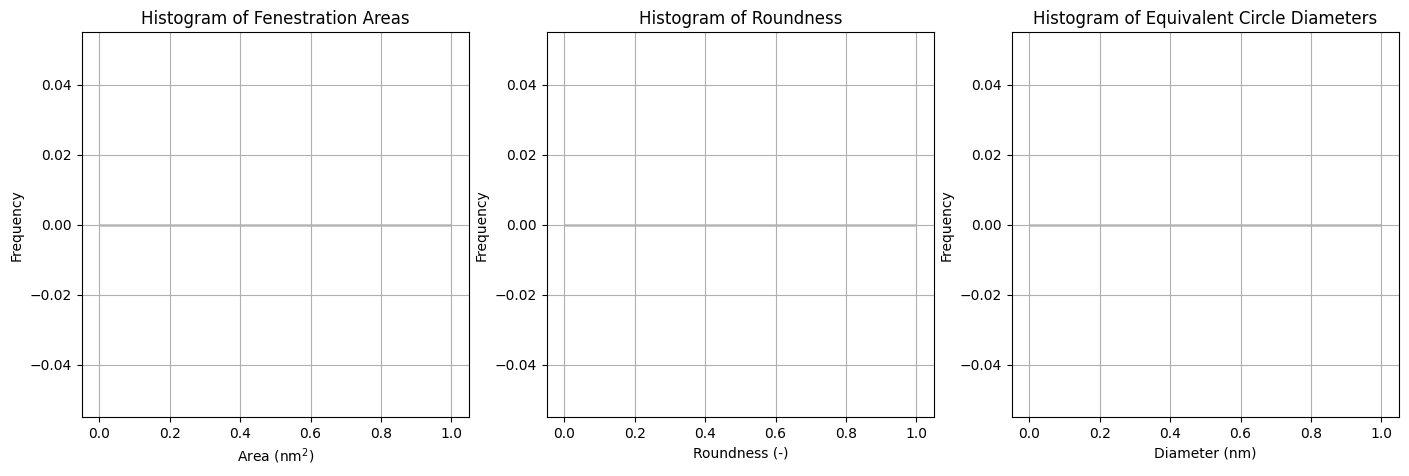

In [44]:
import cv2
import numpy as np
import math

def show_fitted_ellipses(image_path, ellipses):
    image = cv2.imread(image_path)
    for ellipse in ellipses:
        cv2.ellipse(image, ellipse, (0, 0, 255), 1)
        center, axes, angle = ellipse
        center_x, center_y = center
        major_axis_length, minor_axis_length = axes
        rotation_angle = angle
        # print(center_x, center_y)
        cv2.circle(image, (int(center_x), int(center_y)),radius=1, color=(0, 0, 255), thickness=-1)

        # print("Center:", center)
        # print("Major Axis Length:", major_axis_length)
        # print("Minor Axis Length:", minor_axis_length)
        # print("Rotation Angle:", rotation_angle)

    cv2_imshow(image)

def fit_ellipses(filtered_contours, centers):
    ellipses = []
    for contour, cnt_center in zip(filtered_contours, centers):
        if len(contour) >= 5:  # Ellipse fitting requires at least 5 points
            ellipse = cv2.fitEllipse(contour) # TODO: maybe try a different computation, if this does not work well
            # ellipse = cv2.minAreaRect(cnt) # the fitEllipse functions fails sometimes(when the fenestration is on the edge and only a part of it is visible)
            dist = cv2.norm(cnt_center, ellipse[0])
            # print(dist)
            if dist < 20:
                ellipses.append(ellipse)
    return ellipses

def find_fenestration_contours(image_path):
    seg_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # image = cv2.cvtColor(seg_mask, cv2.COLOR_GRAY2RGB)
    # image_el = image.copy()
    # cv2.drawContours(image, contours, -1, (0, 0, 255), 1)
    # cv2_imshow(image)

    # Remove noise and small artifacts
    min_contour_area = 10
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    return filtered_contours

def find_contour_centers(contours):
    contour_centers = []
    for cnt in contours:
        M = cv2.moments(cnt)
        center_x = int(M['m10'] / M['m00'])
        center_y = int(M['m01'] / M['m00'])
        contour_centers.append((center_x, center_y))
    return contour_centers

def equivalent_circle_diameter(major_axis_length, minor_axis_length):
    return math.sqrt(4 * major_axis_length * minor_axis_length)

def show_statistics(fenestration_areas, roundness_of_ellipses, equivalent_diameters):
    plt.figure(figsize=(17, 5))

    # Plot histogram of fenestration areas
    plt.subplot(1, 3, 1)
    plt.hist(fenestration_areas, bins=20, color='red', edgecolor='black')
    plt.title('Histogram of Fenestration Areas')
    plt.xlabel('Area ($\mathrm{nm}^2$)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of roundness
    plt.subplot(1, 3, 2)
    plt.hist(roundness_of_ellipses, bins=20, color='blue', edgecolor='black')
    plt.title('Histogram of Roundness')
    plt.xlabel('Roundness (-)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of equivalent circle diameters
    plt.subplot(1, 3, 3)
    plt.hist(equivalent_diameters, bins=20, color='green', edgecolor='black')
    plt.title('Histogram of Equivalent Circle Diameters')
    plt.xlabel('Diameter (nm)')
    plt.ylabel('Frequency')
    plt.grid(True)



# Mask statistics debug
# One pixel corresponds to 10.62 nm
image_path = "./gdrive/MyDrive/ROIs_manually_corrected/augment_mask/_0_379.tif"
image_path = "./gdrive/MyDrive/ROIs_manually_corrected/old11_CA150_NE_01.tif" # Image from semiautomatic labeling


pixel_size_nm = 10.62
contours = find_fenestration_contours(image_path)
fenestration_areas = [cv2.contourArea(cnt) * (pixel_size_nm**2) for cnt in contours]
contour_centers = find_contour_centers(contours)
ellipses = fit_ellipses(contours, contour_centers)

# Show image of fitted ellipses
# show_fitted_ellipses(image_path, ellipses)

roundness_of_ellipses = []
equivalent_diameters = []

for ellipse in ellipses:
    center, axes, angle = ellipse
    # center_x, center_y = center
    major_axis_length, minor_axis_length = axes
    roundness = minor_axis_length/major_axis_length
    roundness_of_ellipses.append(roundness)
    # rotation_angle = angle
    diameter = pixel_size_nm * equivalent_circle_diameter(major_axis_length, minor_axis_length)
    equivalent_diameters.append(diameter) # TODO: tohle taky do nm?

show_statistics(fenestration_areas, roundness_of_ellipses, equivalent_diameters)


# Display the number of circles and their fitted ellipses
print("Number of fenestrations:", len(contours))
print("Number of fitted ellipses:", len(ellipses))

In [ ]:
# # Wavelet filtering debug

image_folder = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"
images = os.listdir(image_folder)
image_name = images[0]
image = cv.imread(os.path.join(image_folder, image_name), 0)
# cv2_imshow(image)

denoised_image = wavelet_denoise(image)
# cv2_imshow(denoised_image)



# U-Net definition

In [45]:
# import torchvision.transforms.functional as TF


def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )
    return conv

#def cropper(og_tensor, target_tensor):
#    og_shape = og_tensor.shape[2]
#    target_shape = target_tensor.shape[2]
#    delta = (og_shape - target_shape) // 2
#    cropped_og_tensor = og_tensor[:,:,delta:og_shape-delta,delta:og_shape-delta]
#    return cropped_og_tensor


def padder(left_tensor, right_tensor, device: str):
  # left_tensor is the tensor on the encoder side of UNET
  # right_tensor is the tensor on the decoder side  of the UNET

    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)

    return right_tensor.to(device)



class UNET(nn.Module):
    def __init__(self, in_channels, out_channels, device):
        super(UNET, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.device = device

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.down_conv_1 = double_conv(in_ch=self.in_channels,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)

        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)

        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.out_channels,kernel_size=1,stride=1)

    def forward(self, x):
        # x = x.to(self.device)
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)

        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1, self.device) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution

        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2, self.device)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)

        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3, self.device)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)

        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4, self.device)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)

        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

# Training function definition

In [46]:
def train_fn(loader, model, optimizer, loss_fn, scaler, train_losses):
    loop = tqdm(loader)
    running_loss = 0
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # forward
        with torch.cuda.amp.autocast():
            predictions = model(data) # TODO: shoud this be wrapped in sigmoid???
            loss = loss_fn(torch.sigmoid(predictions), targets)

        # backward
        optimizer.zero_grad() # Zero the gradients

        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

        # update tqdm loop
        loop.set_postfix(loss = loss.item())
        # print(batch_idx)
    number_of_batches = batch_idx+1
    train_losses.append(running_loss/number_of_batches)

#Patch creation

In [47]:
CREATE_NEW_PATCHES = False
SAVE_PATCHES_TO_DISK = False
# Example usage:

image_folder = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"
mask_folder = "./gdrive/MyDrive/ROIs_manually_corrected/train_masks"

if CREATE_NEW_PATCHES:
    patch_size = 512  # Define your patch size here
    if SAVE_PATCHES_TO_DISK:
        output_folder = "./gdrive/MyDrive/ROIs_manually_corrected/patches" # TODO: save created patches somewhere on disk
    else:
        output_folder = os.getcwd()
    image_patches_path, mask_patches_path = create_image_patches(image_folder, mask_folder, output_folder, patch_size)
else: # The patches will be read from disk
    output_folder = "./gdrive/MyDrive/ROIs_manually_corrected/patches"
    image_patches_path = os.path.join(output_folder, 'image_patches')
    mask_patches_path = os.path.join(output_folder, 'mask_patches')


# Training

In [48]:
# Training parameters
learning_rate = 1e-4
batch_size = 5
num_epochs = 2
num_workers = 2
pin_memory = False # TODO: check
load_model = False

# Define dataloaders for training
data_split = 0.1

image_patches_path = image_folder
mask_patches_path = mask_folder

train_loader, val_loader, train_indices = get_loaders(
    image_patches_path,
    mask_patches_path,
    data_split,
    batch_size,
    train_transform,
    val_transform,
    num_workers,
    pin_memory
)

model = UNET(in_channels=1, out_channels=1, device=DEVICE).to(DEVICE)


# Wandb debug

In [49]:
!pip install wandb
# train.py
import wandb
wandb.login()


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [52]:
torch.set_grad_enabled(True)

weights = getClassWeights(mask_patches_path, train_indices)
w1 = weights[0]
w2 = weights[1]
# print(w2/w1)

# Launch 5 experiments, trying different dropout rates
batch_sizes = [5]
for i in range(len(batch_sizes)):
    wandb.init(
        project="LSEC_segmentation",
        config={
            "epochs": 10,
            "batch_size": batch_sizes[i],
            "lr": 1e-3,
            # "dropout": random.uniform(0.01, 0.80),
            })
    config = wandb.config
    model = UNET(in_channels=1, out_channels=1, device=DEVICE).to(DEVICE)
    # n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # # Make the loss and optimizer
    # loss_func = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)


    loss_fn = nn.BCEWithLogitsLoss(pos_weight=w2/w1) # cross entropy loss for more than one class(out channels)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler()

   # Training
    train_losses = []
    val_losses = []
    dice_scores = []

    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_loader):


            images = images.to(device=DEVICE)
            labels = labels.float().unsqueeze(1).to(device=DEVICE)

            # forward
            with torch.cuda.amp.autocast():
                predictions = torch.sigmoid(model(images))
                predictions = (predictions > 0.5).float()
                train_loss = loss_fn(predictions, labels)

            # backward
            optimizer.zero_grad() # Zero the gradients

            # loss.backward()
            # optimizer.step()
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()


            # images, labels = images.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            # preds = torch.sigmoid(model(images)) # TODO: vystupy modelu bez sigmoidy jsou zaporny hodnoty
            # preds = (preds > 0.5).float()
            # train_loss = loss_func(preds, labels)
            # optimizer.zero_grad()
            # train_loss.backward()
            # optimizer.step()

            example_ct += len(images)
            metrics = {"train/train_loss": train_loss,
                    #    "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                       "train/example_ct": example_ct}

            # if step + 1 < n_steps_per_epoch: # TODO: why this condition?
                # 🐝 Log train metrics to wandb
            wandb.log(metrics)

            step_ct += 1
        accuracy = check_accuracy(val_loader, model, val_losses, dice_scores, DEVICE, loss_fn)
        # val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # 🐝 Log train and validation metrics to wandb
        # val_metrics = {"val/val_loss": val_loss,
        #                "val/val_accuracy": accuracy}
        val_metrics = {"val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

        # print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # If you had a test set, this is how you could log it as a Summary metric
    # wandb.summary['test_accuracy'] = 0.8

    # 🐝 Close your wandb run
    wandb.finish()

OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 97.06 MiB is free. Process 4300 has 14.65 GiB memory in use. Of the allocated memory 14.27 GiB is allocated by PyTorch, and 250.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [38]:
# %%timeit
model_path = os.path.join(model_folder,"my_checkpoint.pth.tar")
LOAD_MODEL = False
if LOAD_MODEL:
    load_state_dict(model, model_path)
    # load_checkpoint(torch.load(model_path), model)
    # check_accuracy(val_loader, model, device=DEVICE)
else:
    weights = getClassWeights(mask_patches_path, train_indices)
    w1 = weights[0]
    w2 = weights[1]
    # print(w2/w1)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=w2/w1) # cross entropy loss for more than one class(out channels)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler() # ilastik
    # summary(model, (3, 512, 512))

    train_losses = []
    val_losses = []
    dice_scores = []
    best_accuracy = 0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}")
        train_fn(train_loader, model, optimizer, loss_fn, scaler, train_losses)

        # save model
        checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
        }
        # check accuracy
        accuracy = check_accuracy(val_loader, model, val_losses, dice_scores, DEVICE, loss_fn)
        if accuracy > best_accuracy: # using dice score right now
            save_state_dict(model, model_path)
            # save_checkpoint(model, model_path)
        accuracy = max(accuracy, best_accuracy)

        # print some examples to a folder
        # if(epoch % 5 == 0):
        view_prediction(val_loader, model, device = DEVICE)
        # save_predictions_as_imgs(val_loader, model, folder=model_folder, device = DEVICE)

Epoch 0


  0%|          | 0/31 [00:00<?, ?it/s]


EOFError: 

# Training evaluation

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [ ]:
plt.plot(dice_scores, label='Dice score')
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.title('Dice Score Over Time')
plt.legend()
plt.show()

# Inference

In [ ]:
# Inference on full images
test_image_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_01.tif"
output_folder = "./gdrive/MyDrive/lsec_test"
inference_on_image_with_overlap(model, test_image_path, output_folder)
patch_size = 512
stride = 20

# display(test_image_mask)


# Bioimageio stuff

In [ ]:
# !pip install "bioimageio.core>=0.5,<0.6"

In [ ]:
# @torch.jit.ignore
# def call_np(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class MyModule(nn.Module):
#     @torch.jit.export
#     def forward(self, tensor):
#         done = call_np(tensor)
#         print (done)

# scripted_module = torch.jit.script(MyModule())
# print(scripted_module.forward.graph)
# empty_tensor = torch.empty(3, 4)
# scripted_module.forward(empty_tensor)










In [ ]:
# import torchvision.transforms as transforms
# import numpy as np

# @torch.jit.ignore
# def denoise_image(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class FunctionWrapper(nn.Module):
#   def __init__(self, model):
#     super(FunctionWrapper, self).__init__()
#     self.model = model

#     @torch.jit.export
#     def forward(self, tensor):
#         denoised = denoise_image(tensor)
#         return self.model(denoised)



# device = torch.device('cpu')
# model = UNET(in_channels=1, out_channels=1, device='cpu')
# model.load_state_dict(torch.load(biomodel_path, map_location=device))
# # model.to(device=device)
# model = torch.jit.script(model)
# # wrapper = FunctionWrapper(model)
# wrapper.to(device=device)
# # wrapper = PreprocessingWrapper(denoise, model)
# # model = torch.jit.script(wrapper)
# #
# model.eval()
# torchscript_weights_path = os.path.join(biomodel_folder, 'torchscript_weights.pt')
# torch.jit.save(model, torchscript_weights_path)

# preprocessing=[[{"name": "scale_range",
#                  "kwargs": {"axes": "xy",
#                           #  "min_percentile": min_percentile,
#                             # "max_percentile": max_percentile,
#                             "mode": "per_sample"
#                             }}]]

# threshold = 0.5
# postprocessing = [[{"name": "binarize", "kwargs": {"threshold": threshold}}]]


In [ ]:
# input = np.random.rand(1, 1, 512, 512).astype("float32")  # an example input
# test_inputs = os.path.join(biomodel_folder, "test-input.npy")
# test_outputs = os.path.join(biomodel_folder, "test-output.npy")
# np.save(test_inputs, input)
# with torch.no_grad():
#   output = model(torch.from_numpy(input)).cpu().numpy() # copy to cpu(is on gpu because of jit.script)
#   output = output > threshold
# np.save(test_outputs, output)

# print(input.shape)
# print(output.shape)

In [ ]:
# # create markdown documentation for your model
# # this should describe how the model was trained, (and on which data)
# # and also what to take into consideration when running the model, especially how to validate the model
# # here, we just create a stub documentation
# doc_path = os.path.join(biomodel_folder, "doc.md")
# with open(doc_path, "w") as f:
#     f.write("# My First Model\n")

In [ ]:
# from bioimageio.core.build_spec import build_model
# import torch
# # now we can use the build_model function to create the zipped package.
# # it takes the path to the weights and data we have just created, as well as additional information
# # that will be used to add metadata to the rdf.yaml file in the model zip
# # we only use a subset of the available options here, please refer to the advanced examples and to the
# # function signature of build_model in order to get an overview of the full functionality
# build_model(
#     # the weight file and the type of the weights
#     weight_uri= torchscript_weights_path,
#     weight_type="torchscript",
#     # the test input and output data as well as the description of the tensors
#     # these are passed as list because we support multiple inputs / outputs per model
#     test_inputs=[test_inputs],
#     test_outputs=[test_outputs],
#     input_axes=["bcyx"],
#     output_axes=["bcyx"],
#     # where to save the model zip, how to call the model and a short description of it
#     output_path=os.path.join(biomodel_folder,"model.zip"),
#     name="MyFirstModel",
#     description="a fancy new model",
#     # additional metadata about authors, licenses, citation etc.
#     authors=[{"name": "Gizmo"}],
#     license="CC-BY-4.0",
#     documentation=doc_path,
#     tags=["nucleus-segmentation"],  # the tags are used to make models more findable on the website
#     cite=[{"text": "Gizmo et al.", "doi": "10.1002/xyzacab123"}],
#     pytorch_version=torch.__version__,
#     preprocessing=preprocessing,
#     postprocessing=postprocessing
# )

In [ ]:
# # finally, we test that the expected outptus are reproduced when running the model.
# # the 'test_model' function runs this test.
# # it will output a list of dictionaries. each dict gives the status of a different test that is being run
# # if all of them contain "status": "passed" then all tests were successful
# from bioimageio.core.resource_tests import test_model
# import bioimageio.core
# my_model = bioimageio.core.load_resource_description(os.path.join(biomodel_folder,"model.zip"))
# test_model(my_model)